<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Symmetric Noise 40%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.4
loss_function = 'DampedCELoss' 
dataset = 'aircrafts'
noise_type = 'sym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedCELoss_aircrafts_sym_0.4_0.25_baseline
Model Features: DampedCELoss_aircrafts_sym_0.4_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedCELoss_aircrafts_sym_0.4_0.25
Csv save: DampedCELoss_aircrafts_sym_0.4_0.25
Saving features from Scheme delta = 0.25: DampedCELoss_aircrafts_sym_0.4_0.5
Saving csv for damp_2: DampedCELoss_aircrafts_sym_0.4_0.5


# Declaration of models Net family with Resolution, Epochs, and Batch size

In [4]:
architecture = 'efficientnet-b4'
effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [5]:
import pandas as pd
train_df = pd.read_csv('aircrafts_sym_0.4.csv')
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0548719.jpg,53,0,0
1,aircrafts_original/0/1152266.jpg,93,0,0
2,aircrafts_original/0/0894380.jpg,22,0,0
3,aircrafts_original/0/0716386.jpg,90,0,0
4,aircrafts_original/0/0450014.jpg,85,0,0
...,...,...,...,...
6662,aircrafts_original/99/1227260.jpg,99,99,99
6663,aircrafts_original/99/1320583.jpg,99,99,99
6664,aircrafts_original/99/0792373.jpg,99,99,99
6665,aircrafts_original/99/1691701.jpg,99,99,99


In [4]:
print(train_df.Noisy_labels.tolist())

[89, 79, 91, 18, 84, 56, 81, 23, 39, 20, 81, 85, 0, 30, 62, 13, 47, 53, 21, 84, 60, 39, 14, 93, 98, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 88, 46, 53, 69, 56, 19, 5, 28, 86, 27, 21, 29, 87, 93, 72, 73, 34, 50, 1, 29, 82, 48, 28, 57, 36, 69, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 31, 3, 41, 12, 99, 71, 75, 69, 38, 2, 5, 82, 87, 78, 91, 34, 56, 44, 72, 62, 13, 17, 32, 89, 33, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 61, 3, 4, 62, 73, 74, 32, 45, 16, 79, 16, 1, 12, 8, 77, 8, 88, 13, 21, 97, 20, 13, 64, 54, 52, 90, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 44, 79, 85, 64, 65, 76, 4, 52, 57, 17, 57, 61, 89, 78, 90, 6, 59, 82, 53, 11, 25, 58, 16, 17, 29, 92, 4, 4

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

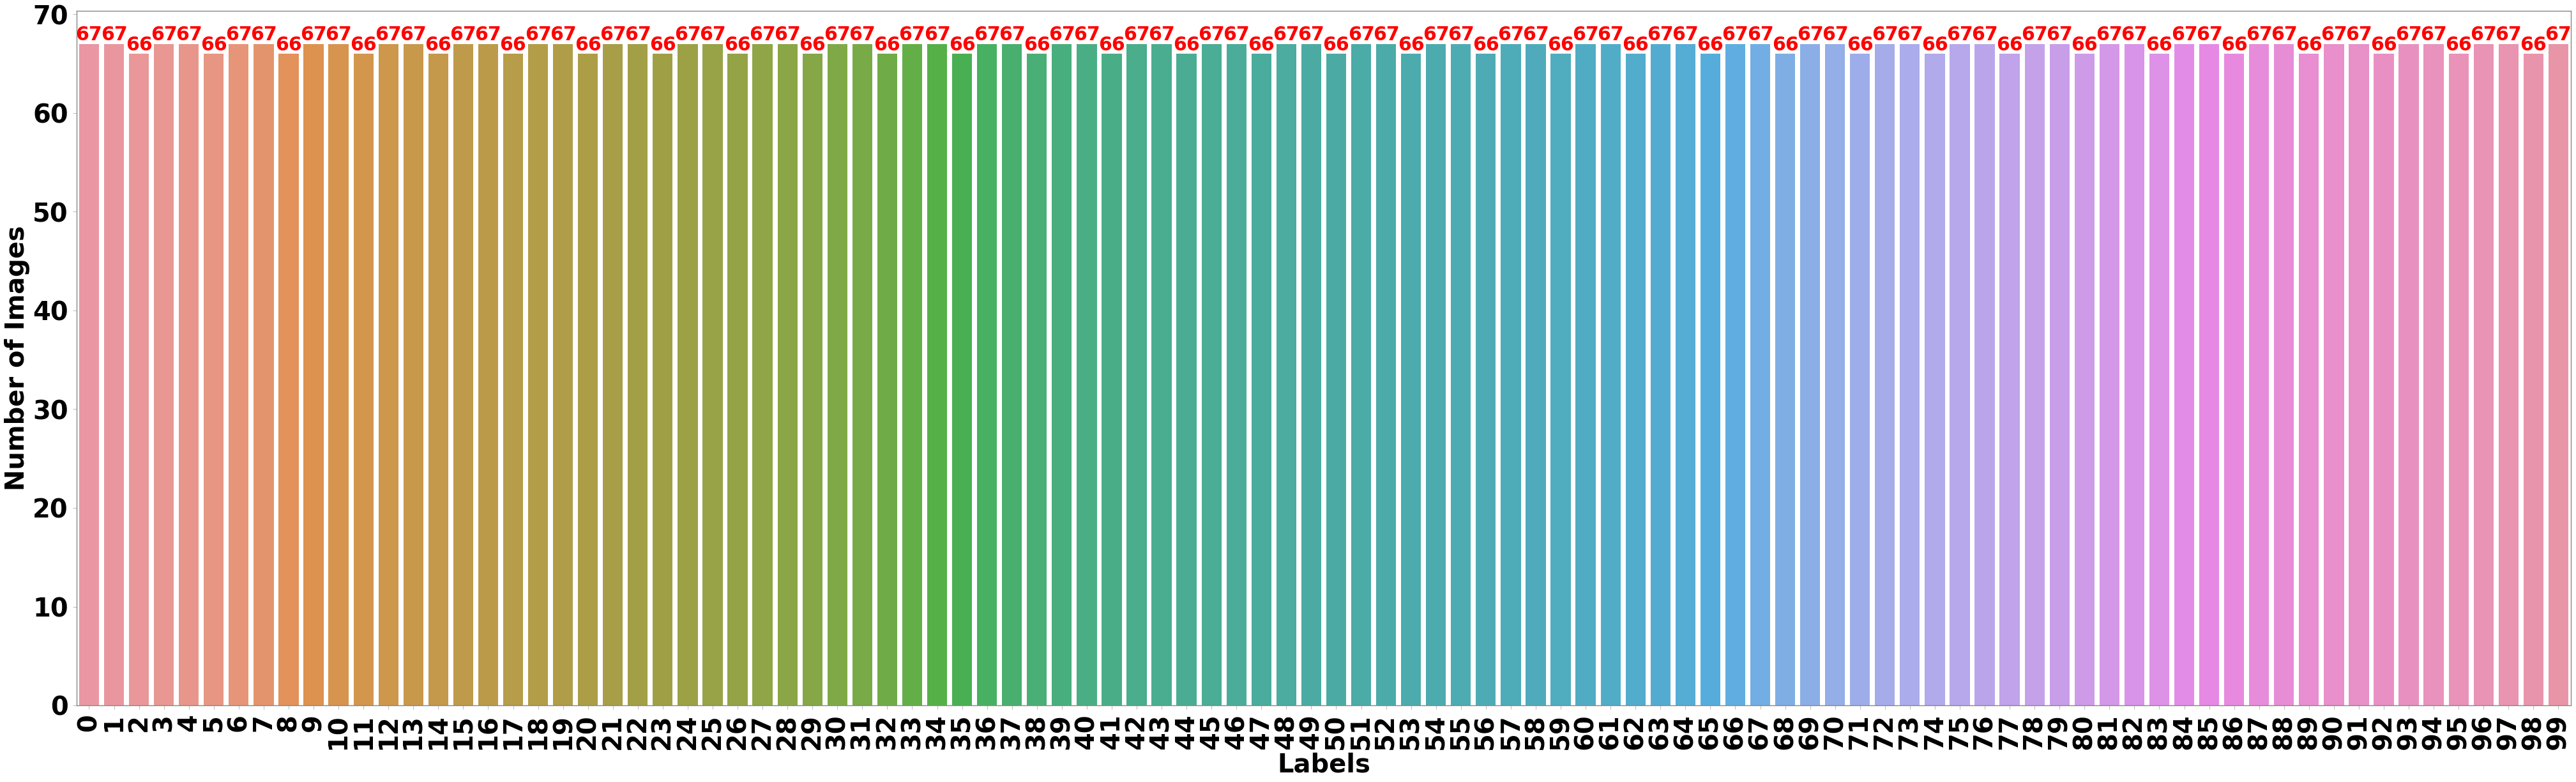

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [6]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [6]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/65/1943358.jpg,65
1,testing/65/1088603.jpg,65
2,testing/65/1714026.jpg,65
3,testing/65/1806208.jpg,65
4,testing/65/1759298.jpg,65
...,...,...
3328,testing/80/0606801.jpg,80
3329,testing/80/1088415.jpg,80
3330,testing/80/1455400.jpg,80
3331,testing/80/1686317.jpg,80


Text(0, 0.5, 'Number of Images')

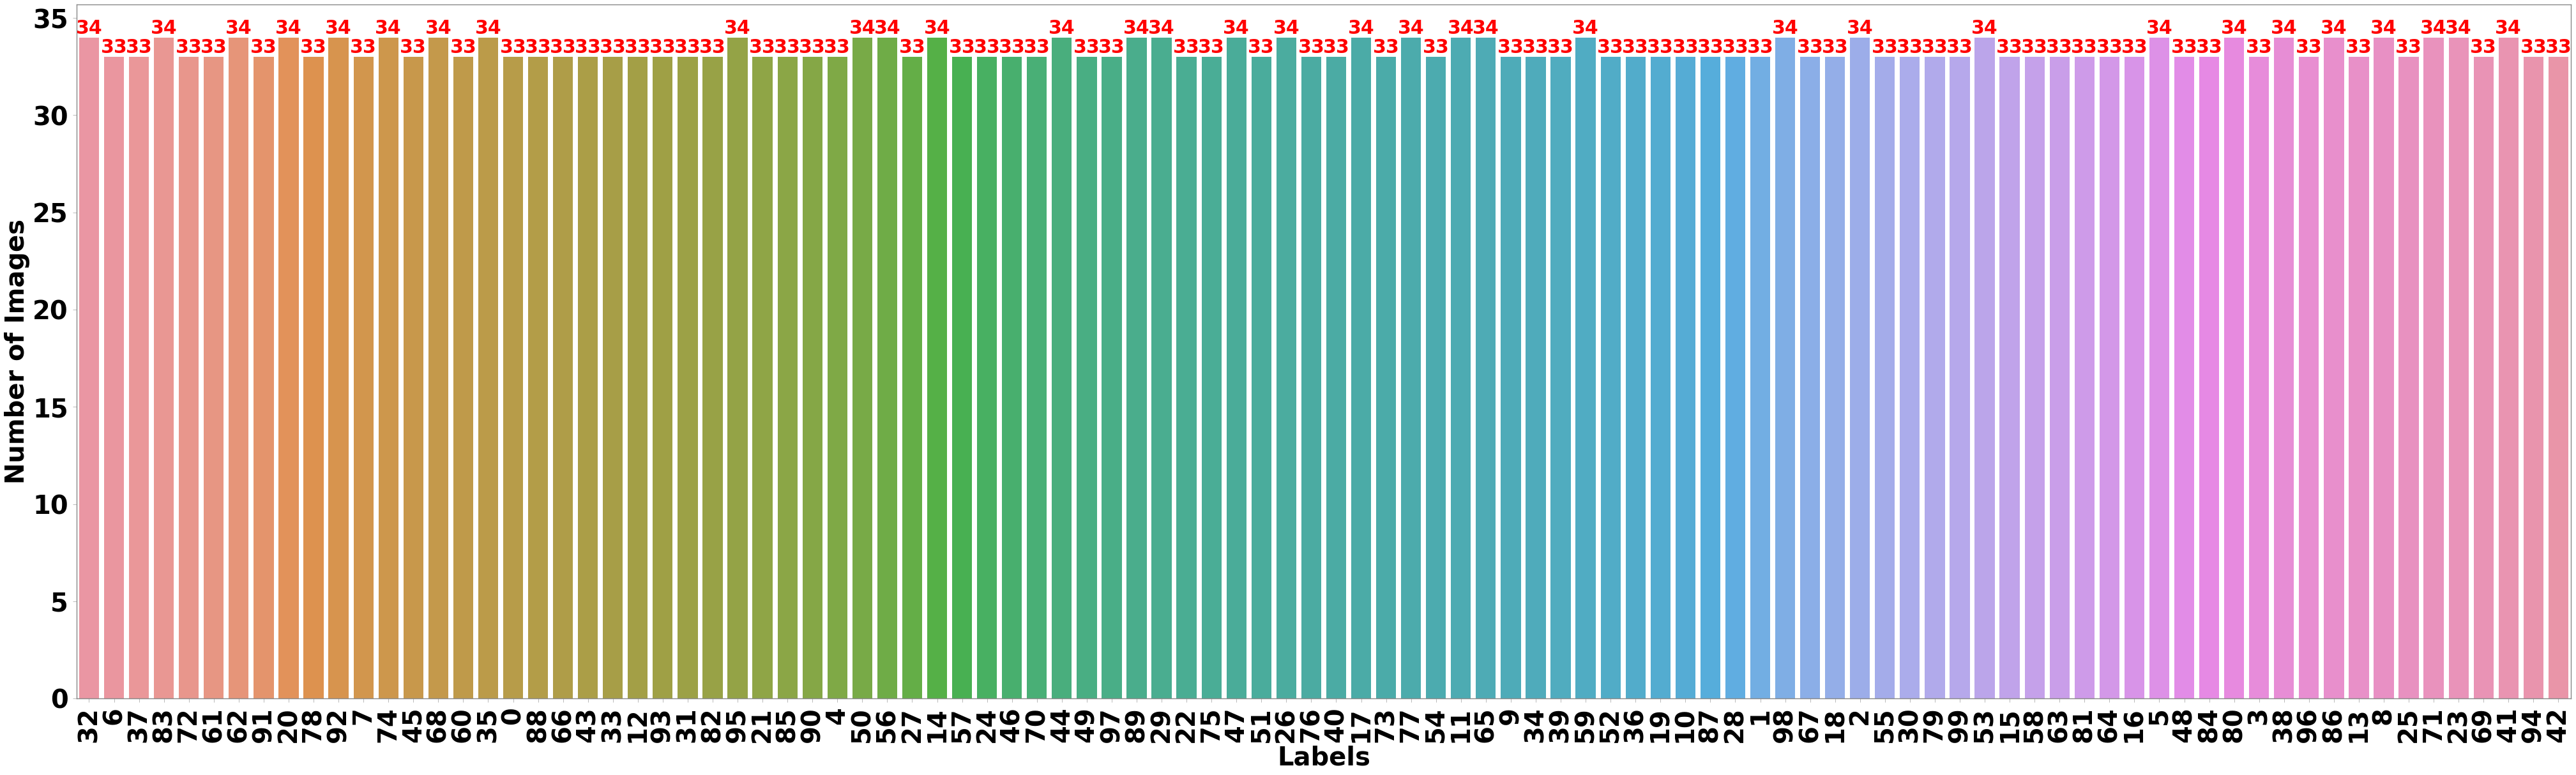

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Preparation of data for learner (Fastai learner)

In [12]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [13]:
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


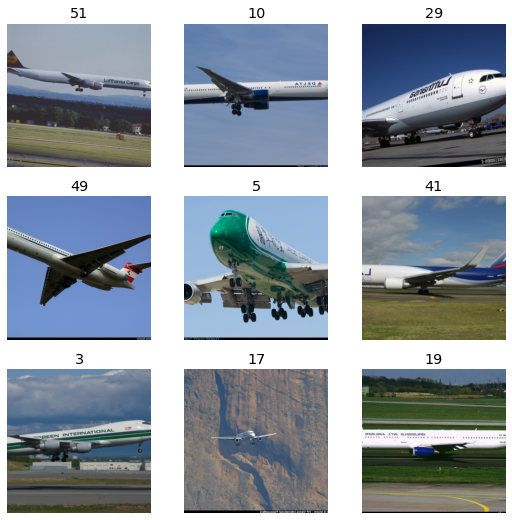

In [14]:
data0.show_batch()

In [15]:
import damped_losses as losses
loss_func = losses.DampedCELossFlat(num_classes=196,delta=0.0,reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=196)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [16]:
best_pth = 'ce_aircrafts_dumpsCls_sym40_b4'
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= ce_aircrafts_dumpsCls_sym40_b4


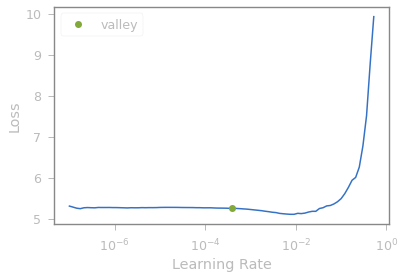

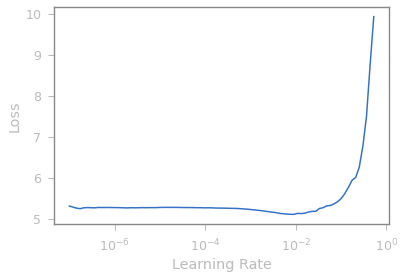

In [17]:
learn.lr_find()
learn.recorder.plot_lr_find()

Parameters used in SECLoss functions are;
epochs: 120  train_batch_size: 128  lr: 0.01  alpha: 0.1 beta: 1.0


epoch,train_loss,valid_loss,accuracy,time
0,4.292266,4.094773,0.109527,01:50
1,3.920114,4.455193,0.089272,01:49
2,3.591720,4.007605,0.196549,01:49
3,3.300193,3.878834,0.237059,01:49
4,3.013996,3.693626,0.339085,01:49
5,2.641293,3.595261,0.385596,01:49
6,2.004404,3.841552,0.411103,01:49
7,1.365450,3.988927,0.414104,01:49
8,0.953066,4.120222,0.411103,01:49
9,0.752775,4.149770,0.414104,01:49


Better model found at epoch 0 with accuracy value: 0.10952737927436829.


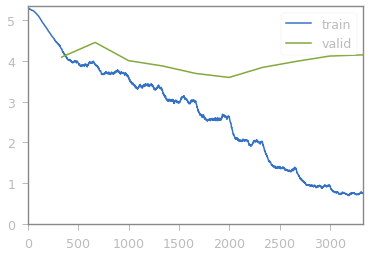

Better model found at epoch 2 with accuracy value: 0.19654913246631622.
Better model found at epoch 3 with accuracy value: 0.23705926537513733.
Better model found at epoch 4 with accuracy value: 0.33908477425575256.
Better model found at epoch 5 with accuracy value: 0.3855963945388794.
Better model found at epoch 6 with accuracy value: 0.4111027717590332.
Better model found at epoch 7 with accuracy value: 0.41410353779792786.


In [18]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

# Unfreeze the Learner
fast.ai freezes the pre-trained part when we create the model. So up to this point, 
we only trained the last layer block. Next, we will unfreeze the pre-trained part and train the whole model.

In [19]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.874232,4.056488,0.418605,01:49
1,0.829117,4.156453,0.405101,01:49
2,0.768045,4.320976,0.394599,01:50
3,0.666775,4.670378,0.360090,01:49
4,0.621636,4.782050,0.373593,01:49
5,0.825068,5.189761,0.321080,01:50
6,0.808534,5.452219,0.288822,01:49
7,0.922352,5.693877,0.296324,01:49
8,1.156399,5.830485,0.262566,01:49
9,1.210694,5.825195,0.272318,01:49


Better model found at epoch 0 with accuracy value: 0.41860464215278625.


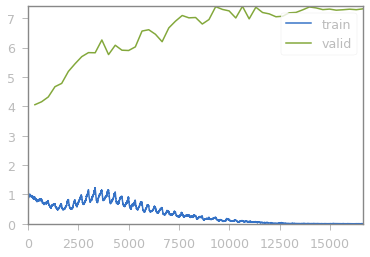

In [20]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [21]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.6850)


In [22]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.6928)


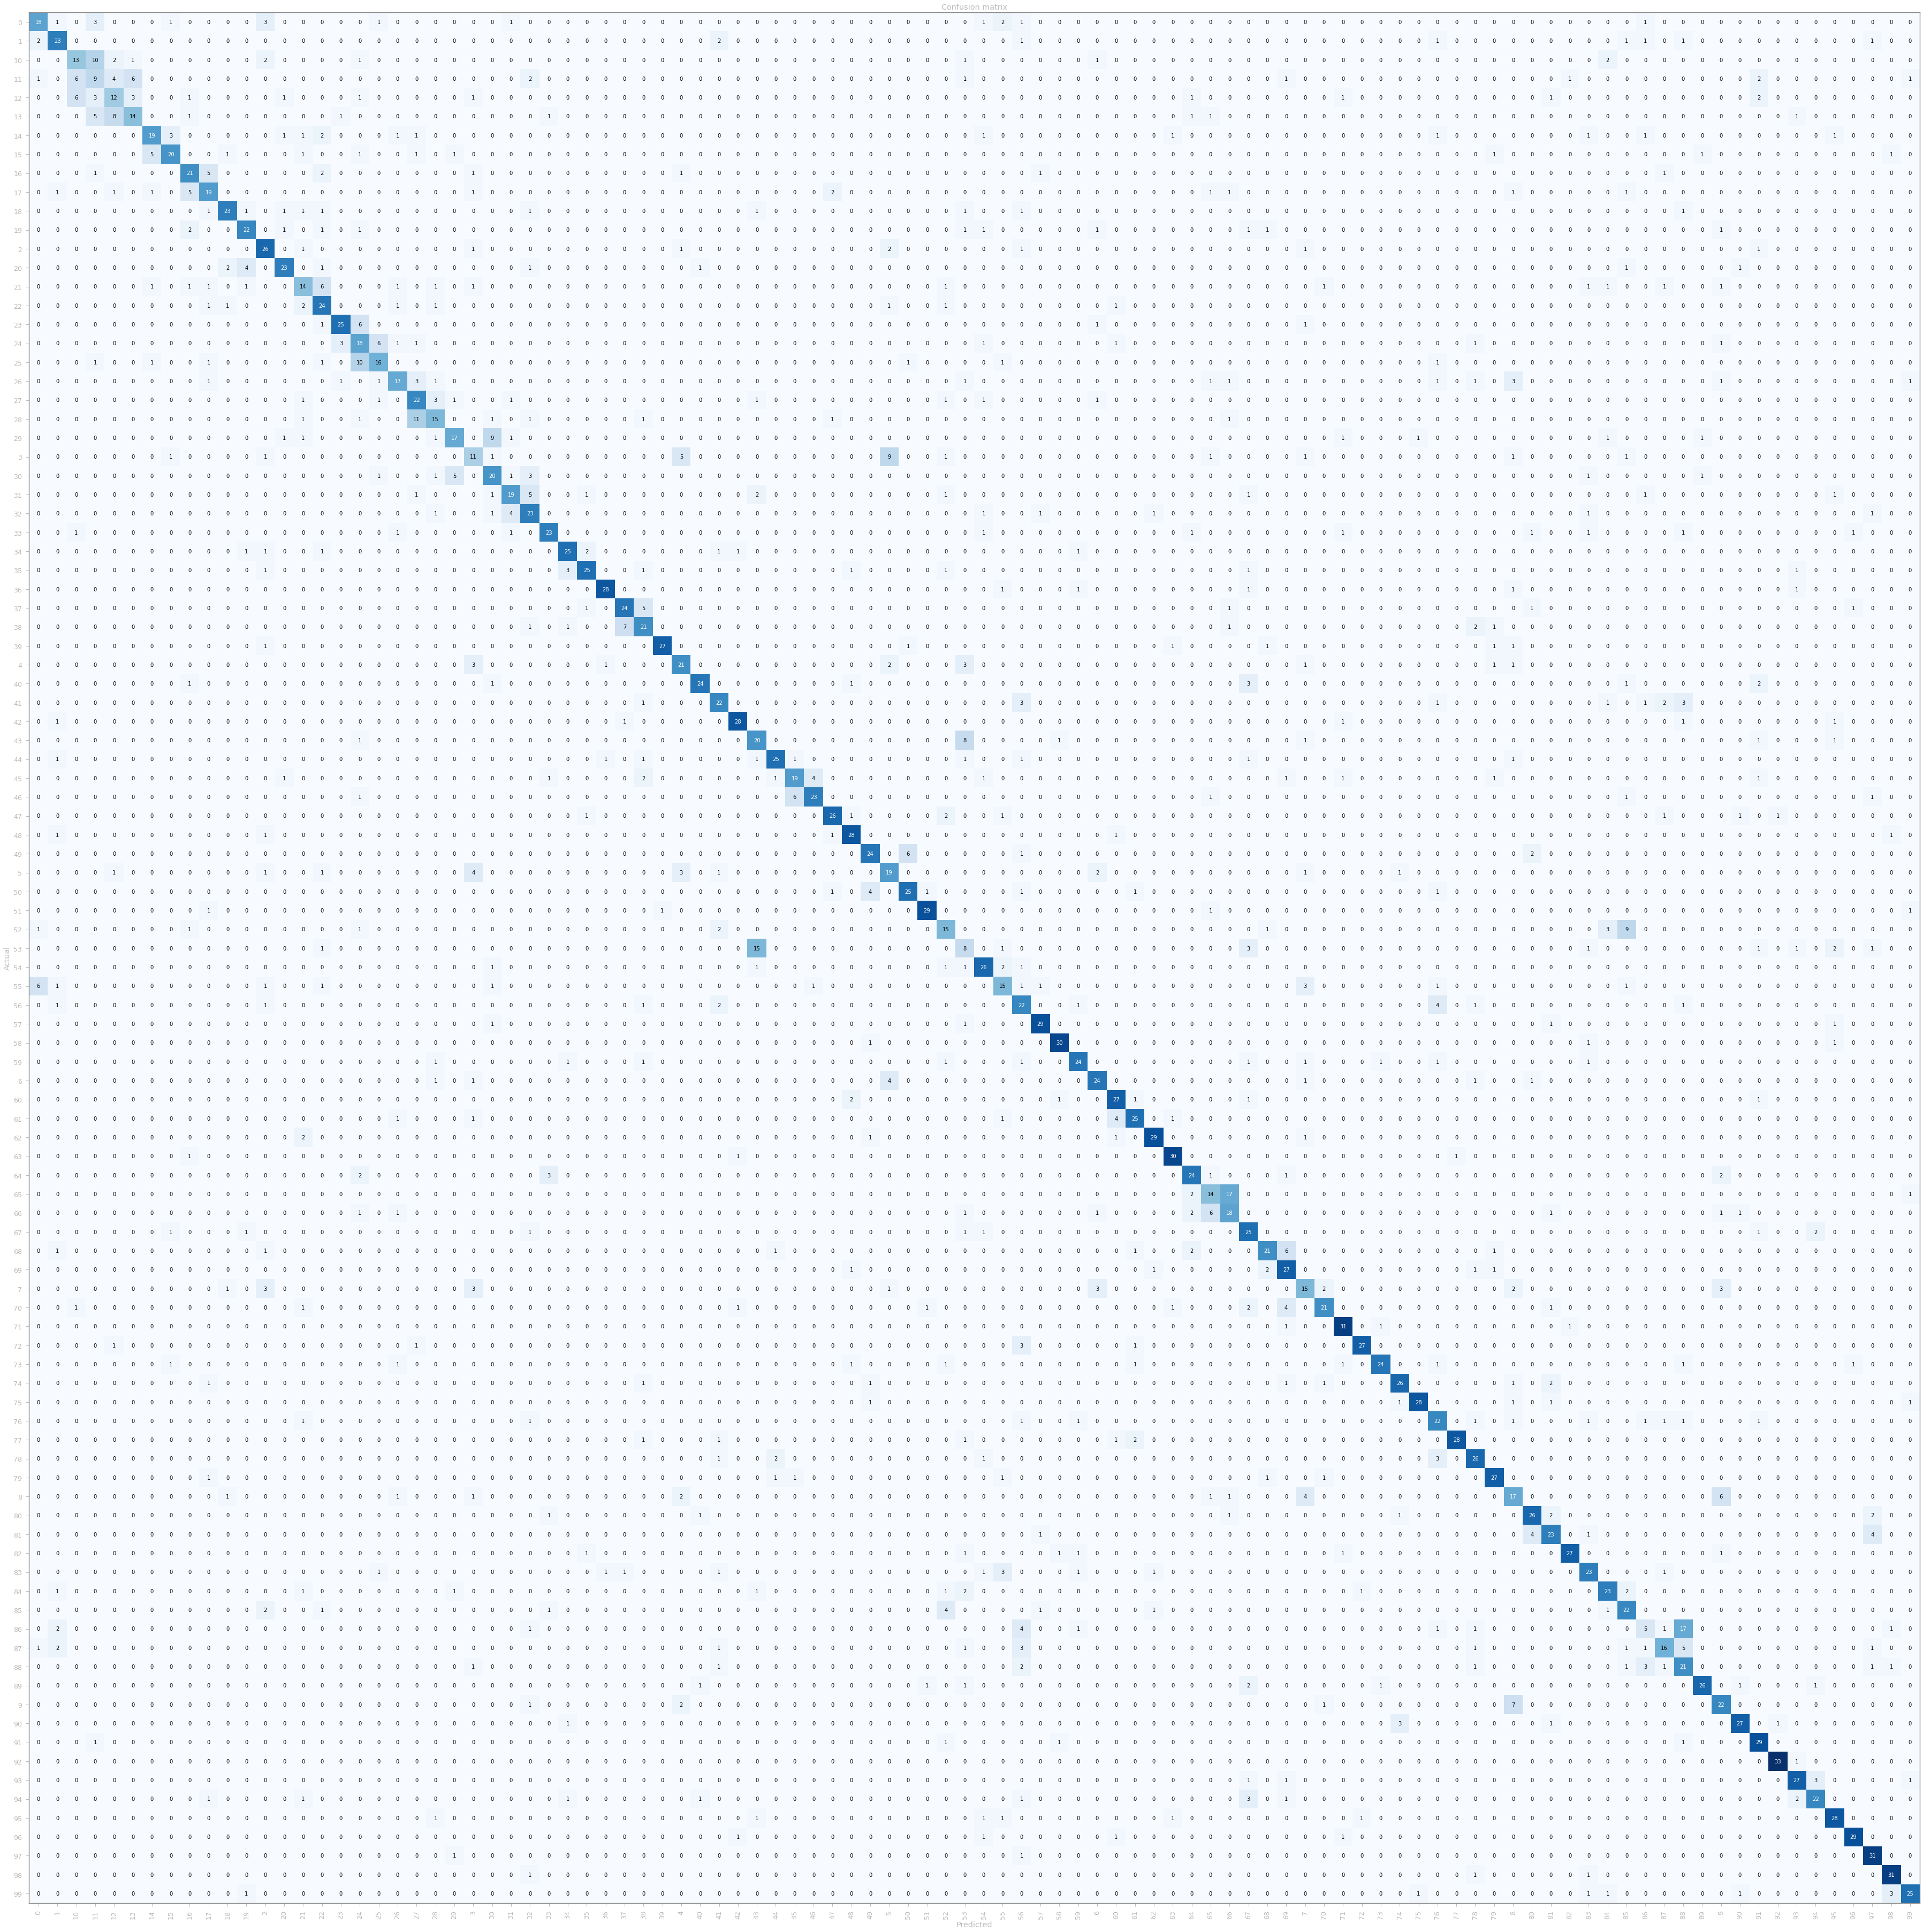

In [23]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [24]:
PATH="models/ce_aircrafts_dumpsCls_sym40_baseline_b4.p"
torch.save(model.state_dict(), PATH)

In [25]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/ce_aircrafts_dumpsCls_sym40_b4.pth'

In [26]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering
def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=100, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered

delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 86 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6581


epoch,train_loss,valid_loss,accuracy,time
0,0.588709,0.349171,0.787994,01:49


Better model found at epoch 0 with accuracy value: 0.7879939079284668.


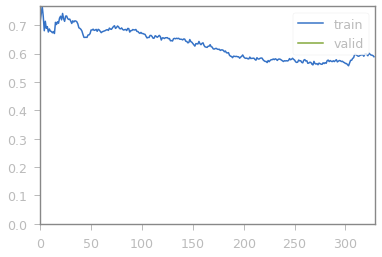

************Round:  0
TTA Accuracy:0.7110711336135864
cycle 0 Error Rate is [{0: (1.2899355032248372, 28.892886638641357)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 79 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6502


epoch,train_loss,valid_loss,accuracy,time
0,0.476737,0.275585,0.786923,01:46


Better model found at epoch 0 with accuracy value: 0.7869230508804321.


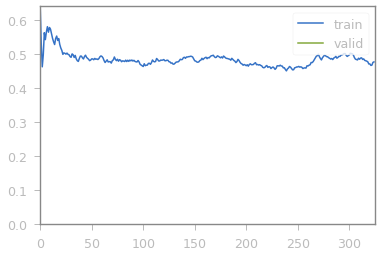

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 80 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6422


epoch,train_loss,valid_loss,accuracy,time
0,0.367942,0.228608,0.774143,01:45


Better model found at epoch 0 with accuracy value: 0.7741432785987854.


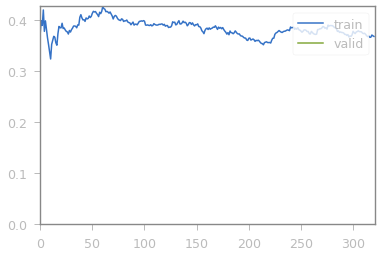

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 74 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6348


epoch,train_loss,valid_loss,accuracy,time
0,0.334539,0.180231,0.752561,01:45


Better model found at epoch 0 with accuracy value: 0.752561092376709.


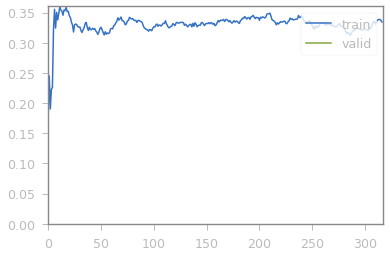

************Round:  3
TTA Accuracy:0.741374135017395
cycle 0 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 67 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6281


epoch,train_loss,valid_loss,accuracy,time
0,0.285141,0.178588,0.730096,01:45


Better model found at epoch 0 with accuracy value: 0.7300955653190613.


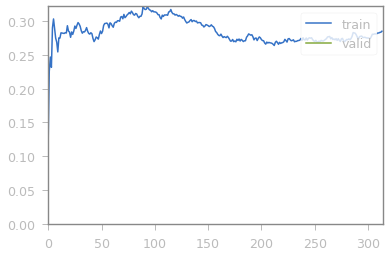

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 54
Min probability = 0.7253731343283583
Dropped 78 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6203


epoch,train_loss,valid_loss,accuracy,time
0,0.263549,0.145377,0.730645,01:42


Better model found at epoch 0 with accuracy value: 0.7306451797485352.


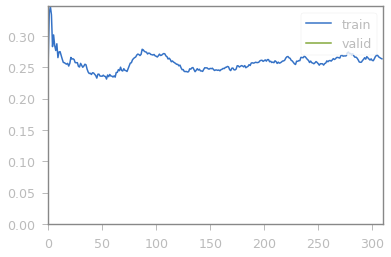

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 71 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6132


epoch,train_loss,valid_loss,accuracy,time
0,0.228712,0.140856,0.712887,01:42


Better model found at epoch 0 with accuracy value: 0.7128874659538269.


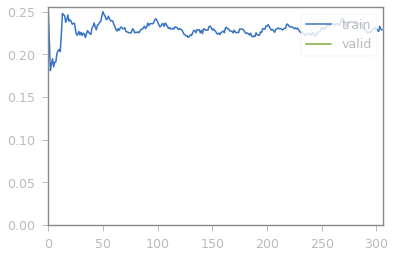

************Round:  6
TTA Accuracy:0.7476747632026672
cycle 0 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 52
Min probability = 0.6985074626865672
Dropped 72 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6060


epoch,train_loss,valid_loss,accuracy,time
0,0.228121,0.113425,0.725248,01:40


Better model found at epoch 0 with accuracy value: 0.7252475023269653.


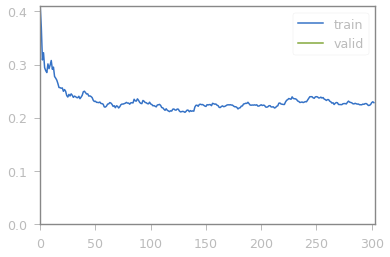

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 51
Min probability = 0.6954545454545454
Dropped 66 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5994


epoch,train_loss,valid_loss,accuracy,time
0,0.205152,0.117206,0.720367,01:40


Better model found at epoch 0 with accuracy value: 0.7203672528266907.


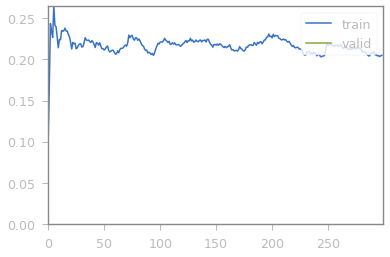

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 51
Min probability = 0.7061538461538461
Dropped 69 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5925


epoch,train_loss,valid_loss,accuracy,time
0,0.200616,0.114210,0.742616,01:39


Better model found at epoch 0 with accuracy value: 0.7426160573959351.


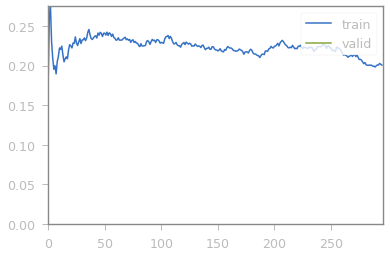

************Round:  9
TTA Accuracy:0.7470747232437134
cycle 0 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 69 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5856


epoch,train_loss,valid_loss,accuracy,time
0,0.220164,0.117271,0.697694,01:37


Better model found at epoch 0 with accuracy value: 0.6976943016052246.


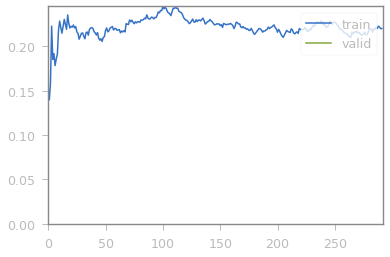

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 68 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5788


epoch,train_loss,valid_loss,accuracy,time
0,0.220685,0.126745,0.726880,01:35


Better model found at epoch 0 with accuracy value: 0.7268798351287842.


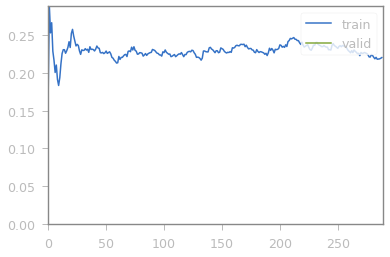

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 65 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5723


epoch,train_loss,valid_loss,accuracy,time
0,0.258878,0.126859,0.721154,01:34


Better model found at epoch 0 with accuracy value: 0.7211538553237915.


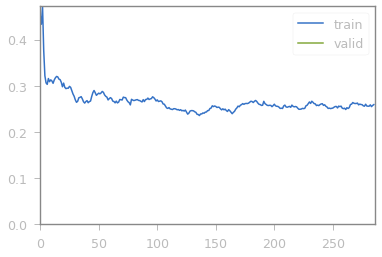

************Round:  12
TTA Accuracy:0.7545754313468933
cycle 0 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 49
Min probability = 0.6890625
Dropped 69 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5654


epoch,train_loss,valid_loss,accuracy,time
0,0.324892,0.176357,0.730088,01:33


Better model found at epoch 0 with accuracy value: 0.730088472366333.


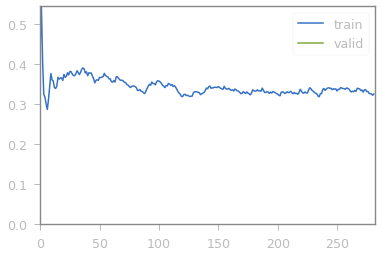

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 64
Min frequency is 48
Min probability = 0.675
Dropped 70 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5584


epoch,train_loss,valid_loss,accuracy,time
0,1.791631,1.531179,0.744624,01:32


Better model found at epoch 0 with accuracy value: 0.7446236610412598.


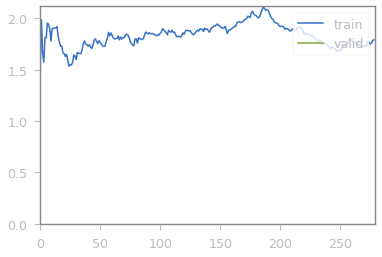

delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,0.414830,0.216098,0.746008,01:48


Better model found at epoch 0 with accuracy value: 0.7460076212882996.


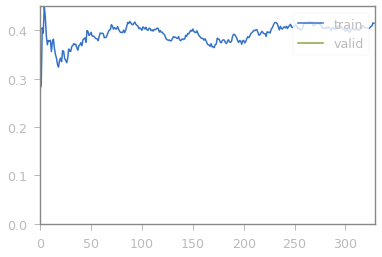

************Round:  0
TTA Accuracy:0.7386738657951355
cycle 1 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 84 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6495


epoch,train_loss,valid_loss,accuracy,time
0,0.254073,0.153889,0.736721,01:46


Better model found at epoch 0 with accuracy value: 0.7367205619812012.


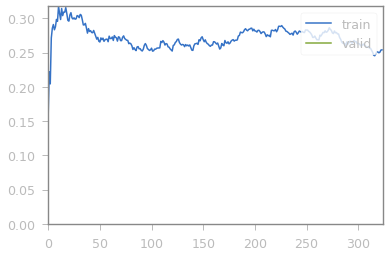

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 87 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6408


epoch,train_loss,valid_loss,accuracy,time
0,0.221032,0.102956,0.750976,01:45


Better model found at epoch 0 with accuracy value: 0.7509757876396179.


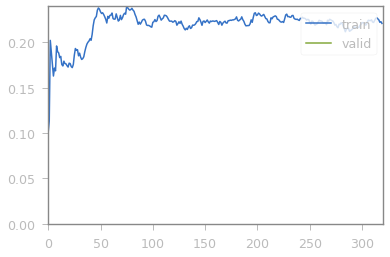

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 76 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6332


epoch,train_loss,valid_loss,accuracy,time
0,0.187902,0.091936,0.737757,01:45


Better model found at epoch 0 with accuracy value: 0.7377567291259766.


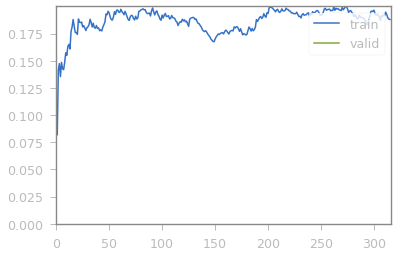

************Round:  3
TTA Accuracy:0.7449744939804077
cycle 1 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 78 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6254


epoch,train_loss,valid_loss,accuracy,time
0,0.165535,0.082822,0.747200,01:42


Better model found at epoch 0 with accuracy value: 0.7472000122070312.


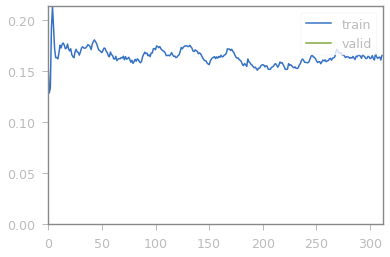

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 75 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6179


epoch,train_loss,valid_loss,accuracy,time
0,0.155188,0.060157,0.732794,01:42


Better model found at epoch 0 with accuracy value: 0.7327935099601746.


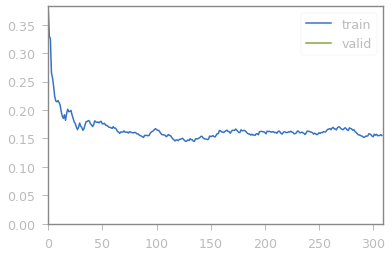

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 56
Min probability = 0.7522388059701492
Dropped 73 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6106


epoch,train_loss,valid_loss,accuracy,time
0,0.139307,0.056139,0.718264,01:40


Better model found at epoch 0 with accuracy value: 0.7182637453079224.


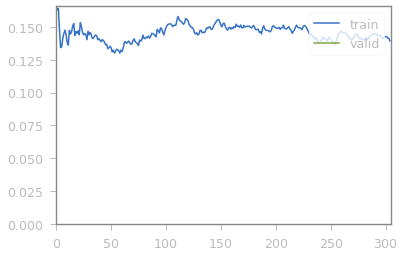

************Round:  6
TTA Accuracy:0.7551755309104919
cycle 1 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 67
Min frequency is 53
Min probability = 0.7119402985074627
Dropped 78 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6028


epoch,train_loss,valid_loss,accuracy,time
0,0.135388,0.058341,0.744398,01:39


Better model found at epoch 0 with accuracy value: 0.7443983554840088.


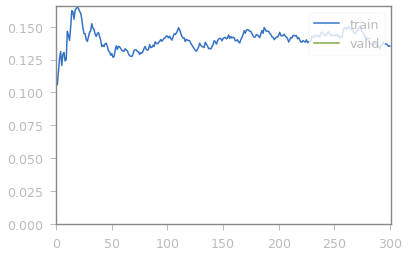

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 74 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5954


epoch,train_loss,valid_loss,accuracy,time
0,0.143460,0.064819,0.752941,01:39


Better model found at epoch 0 with accuracy value: 0.7529411911964417.


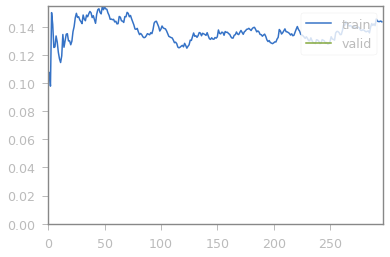

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 52
Min probability = 0.7200000000000001
Dropped 76 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5878


epoch,train_loss,valid_loss,accuracy,time
0,0.145753,0.047456,0.721702,01:39


Better model found at epoch 0 with accuracy value: 0.7217020988464355.


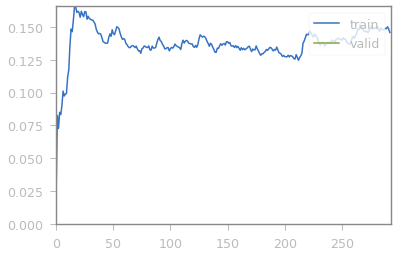

************Round:  9
TTA Accuracy:0.7548754811286926
cycle 1 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806), 24: (11.834408279586018, 24.512451887130737)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 52
Min probability = 0.7200000000000001
Dropped 72 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5806


epoch,train_loss,valid_loss,accuracy,time
0,0.145872,0.070109,0.708010,01:36


Better model found at epoch 0 with accuracy value: 0.7080103158950806.


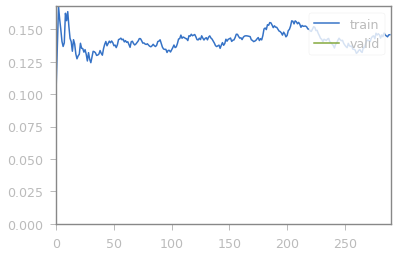

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 64
Min frequency is 52
Min probability = 0.7312500000000001
Dropped 67 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5739


epoch,train_loss,valid_loss,accuracy,time
0,0.159749,0.067508,0.732345,01:34


Better model found at epoch 0 with accuracy value: 0.7323452234268188.


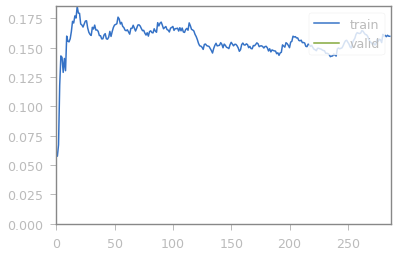

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 63
Min frequency is 50
Min probability = 0.7142857142857143
Dropped 70 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5669


epoch,train_loss,valid_loss,accuracy,time
0,0.169928,0.083984,0.707855,01:35


Better model found at epoch 0 with accuracy value: 0.707855224609375.


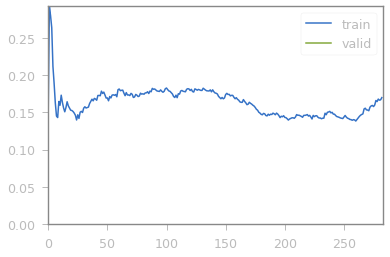

************Round:  12
TTA Accuracy:0.7470747232437134
cycle 1 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806), 24: (11.834408279586018, 24.512451887130737), 27: (14.969251537423133, 25.292527675628662)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 62
Min frequency is 48
Min probability = 0.6967741935483871
Dropped 68 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5601


epoch,train_loss,valid_loss,accuracy,time
0,0.193018,0.110572,0.694643,01:33


Better model found at epoch 0 with accuracy value: 0.6946428418159485.


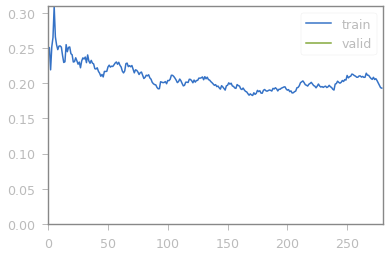

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 62
Min frequency is 47
Min probability = 0.682258064516129
Dropped 73 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5528


epoch,train_loss,valid_loss,accuracy,time
0,1.639036,1.853426,0.718552,01:31


Better model found at epoch 0 with accuracy value: 0.7185520529747009.


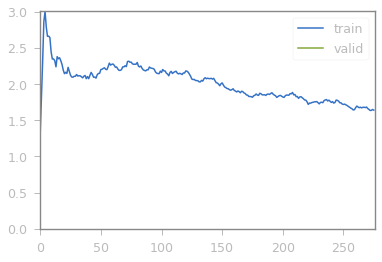

delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 88 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6579


epoch,train_loss,valid_loss,accuracy,time
0,0.288141,0.145738,0.735361,01:48


Better model found at epoch 0 with accuracy value: 0.7353612184524536.


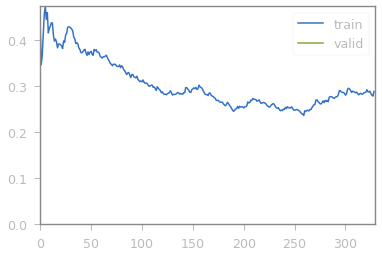

************Round:  0
TTA Accuracy:0.7329732775688171
cycle 2 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806), 24: (11.834408279586018, 24.512451887130737), 27: (14.969251537423133, 25.292527675628662), 30: (1.3199340032998386, 26.702672243118286)}]
delta = 0.10168416076895004
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 82 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6497


epoch,train_loss,valid_loss,accuracy,time
0,0.181482,0.095128,0.756736,01:46


Better model found at epoch 0 with accuracy value: 0.7567359805107117.


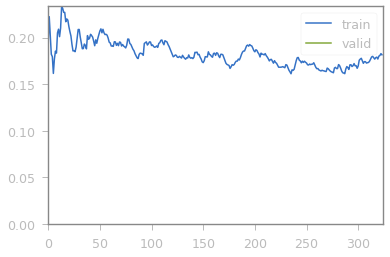

delta = 0.14694631307311828
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 76 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6421


epoch,train_loss,valid_loss,accuracy,time
0,0.149713,0.065408,0.721184,01:45


Better model found at epoch 0 with accuracy value: 0.7211837768554688.


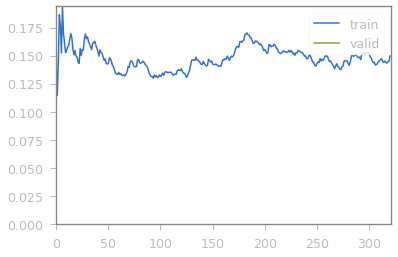

delta = 0.18578620636934853
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 76 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6345


epoch,train_loss,valid_loss,accuracy,time
0,0.129548,0.044181,0.734437,01:45


Better model found at epoch 0 with accuracy value: 0.734436571598053.


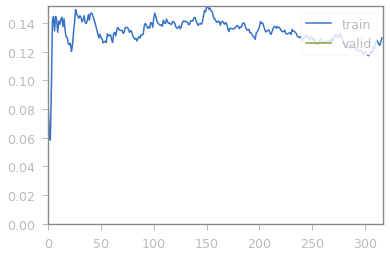

************Round:  3
TTA Accuracy:0.7506750822067261
cycle 2 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806), 24: (11.834408279586018, 24.512451887130737), 27: (14.969251537423133, 25.292527675628662), 30: (1.3199340032998386, 26.702672243118286), 33: (4.829758512074401, 24.932491779327393)}]
delta = 0.21650635094610965
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 75 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6270


epoch,train_loss,valid_loss,accuracy,time
0,0.140865,0.035522,0.723285,01:43


Better model found at epoch 0 with accuracy value: 0.7232854962348938.


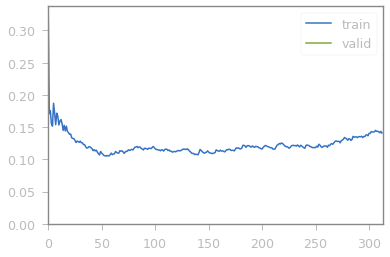

delta = 0.23776412907378838
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 76 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6194


epoch,train_loss,valid_loss,accuracy,time
0,0.103323,0.039539,0.708401,01:42


Better model found at epoch 0 with accuracy value: 0.7084006667137146.


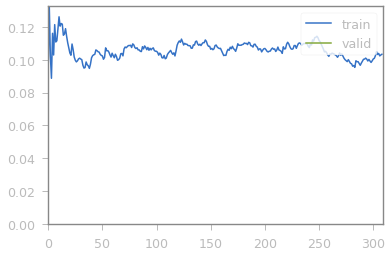

delta = 0.24863047384206832
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 55
Min probability = 0.7388059701492538
Dropped 80 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6114


epoch,train_loss,valid_loss,accuracy,time
0,0.100285,0.033511,0.715221,01:40


Better model found at epoch 0 with accuracy value: 0.7152209281921387.


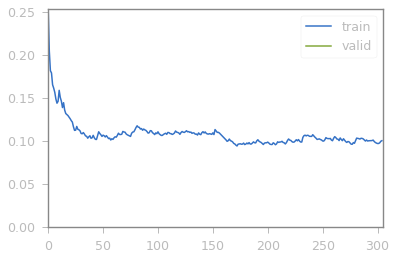

************Round:  6
TTA Accuracy:0.752775251865387
cycle 2 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806), 24: (11.834408279586018, 24.512451887130737), 27: (14.969251537423133, 25.292527675628662), 30: (1.3199340032998386, 26.702672243118286), 33: (4.829758512074401, 24.932491779327393), 36: (8.294585270736466, 24.722474813461304)}]
delta = 0.24863047384206835
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 75 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6039


epoch,train_loss,valid_loss,accuracy,time
0,0.105673,0.027259,0.734051,01:39


Better model found at epoch 0 with accuracy value: 0.7340513467788696.


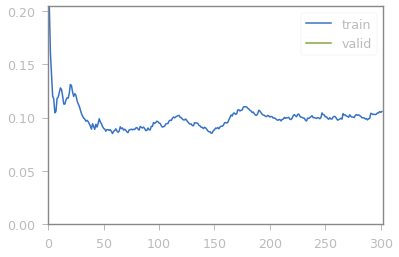

delta = 0.2377641290737884
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 78 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5961


epoch,train_loss,valid_loss,accuracy,time
0,0.095836,0.029913,0.722315,01:38


Better model found at epoch 0 with accuracy value: 0.7223154306411743.


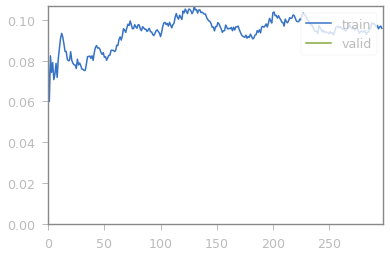

delta = 0.21650635094610968
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 80 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5881


epoch,train_loss,valid_loss,accuracy,time
0,0.091384,0.028730,0.725340,01:37


Better model found at epoch 0 with accuracy value: 0.7253401279449463.


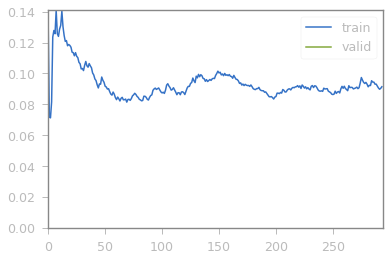

************Round:  9
TTA Accuracy:0.7500749826431274
cycle 2 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806), 24: (11.834408279586018, 24.512451887130737), 27: (14.969251537423133, 25.292527675628662), 30: (1.3199340032998386, 26.702672243118286), 33: (4.829758512074401, 24.932491779327393), 36: (8.294585270736466, 24.722474813461304), 39: (11.789410529473532, 24.992501735687256)}]
delta = 0.18578620636934862
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 66
Min frequency is 51
Min probability = 0.6954545454545454
Dropped 75 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5806


epoch,train_loss,valid_loss,accuracy,time
0,0.101731,0.025941,0.726098,01:36


Better model found at epoch 0 with accuracy value: 0.7260981798171997.


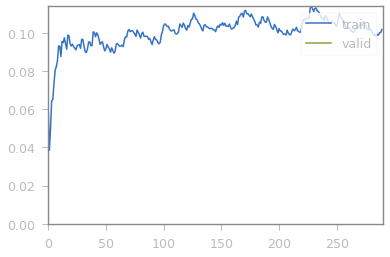

delta = 0.1469463130731183
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 66
Min frequency is 50
Min probability = 0.6818181818181819
Dropped 72 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5734


epoch,train_loss,valid_loss,accuracy,time
0,0.099257,0.031006,0.720768,01:34


Better model found at epoch 0 with accuracy value: 0.7207679152488708.


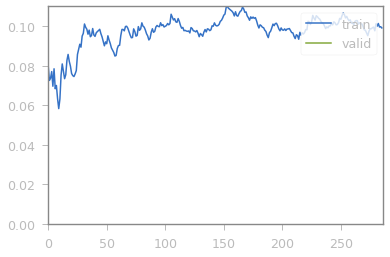

delta = 0.10168416076895001
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 66
Min frequency is 49
Min probability = 0.6681818181818182
Dropped 65 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5669


epoch,train_loss,valid_loss,accuracy,time
0,0.127556,0.037648,0.717564,01:33


Better model found at epoch 0 with accuracy value: 0.7175639867782593.


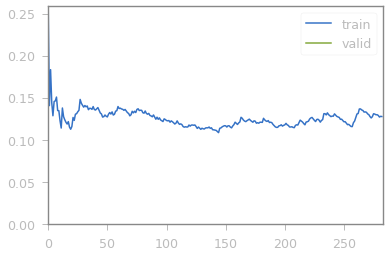

************Round:  12
TTA Accuracy:0.7449744939804077
cycle 2 Error Rate is [{0: (1.2899355032248372, 28.892886638641357), 3: (4.784760761961904, 25.862586498260498), 6: (8.024598770061498, 25.232523679733276), 9: (11.129443527823613, 25.292527675628662), 12: (14.15929203539823, 24.54245686531067), 15: (1.3199340032998386, 26.13261342048645), 18: (5.02474876256187, 25.50255060195923), 21: (8.414579271036448, 24.482446908950806), 24: (11.834408279586018, 24.512451887130737), 27: (14.969251537423133, 25.292527675628662), 30: (1.3199340032998386, 26.702672243118286), 33: (4.829758512074401, 24.932491779327393), 36: (8.294585270736466, 24.722474813461304), 39: (11.789410529473532, 24.992501735687256), 42: (14.969251537423133, 25.50255060195923)}]
delta = 0.05197792270443983
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 65
Min frequency is 47
Min probability = 0.6507692307692308
Dropped 62 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5607


epoch,train_loss,valid_loss,accuracy,time
0,0.149973,0.057012,0.735058,01:32


Better model found at epoch 0 with accuracy value: 0.7350580096244812.


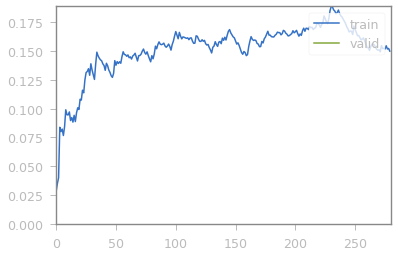

delta = 1.416384724411995e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 65
Min frequency is 46
Min probability = 0.6369230769230769
Dropped 66 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5541


epoch,train_loss,valid_loss,accuracy,time
0,1.713527,1.883304,0.729242,01:31


Better model found at epoch 0 with accuracy value: 0.7292418479919434.


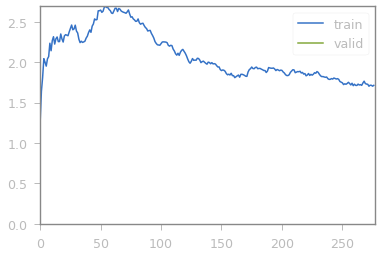

In [27]:

# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        print(f'delta = {delta}')
        loss_func = losses.DampedCELossFlat(num_classes=196,delta=delta,reduction ='mean')

        k_samples = 100
        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
#         print("dynamic LR", dynamic_lr)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
    #     data_per_serie[n+1]
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    #     learn = ( learner_type(databunch, model,metrics=[accuracy,top_5],loss_func=loss,cbs=[ShowGraphCallback(),history]).to_fp16())
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
#         learn.split( lambda m: (model._conv_head) )
        learn.unfreeze() 
        learn.load(best_pth)
#         learn.fit_one_cycle(epochs_per_serie, max_lr=slice(min_lr,lr),cbs=[SaveModelCallback(learn,metrics=[accuracy], name=best_pth)])
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            acc.append(tta_acc)
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH="models/ce_aircrafts_dumps25_Cls_sym40_b4_"+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv("CSVz/ce_aircrafts_dumps25_Cls_sym40_b4_"+str(c)+"_"+str(n)+".csv", index = False)     
    

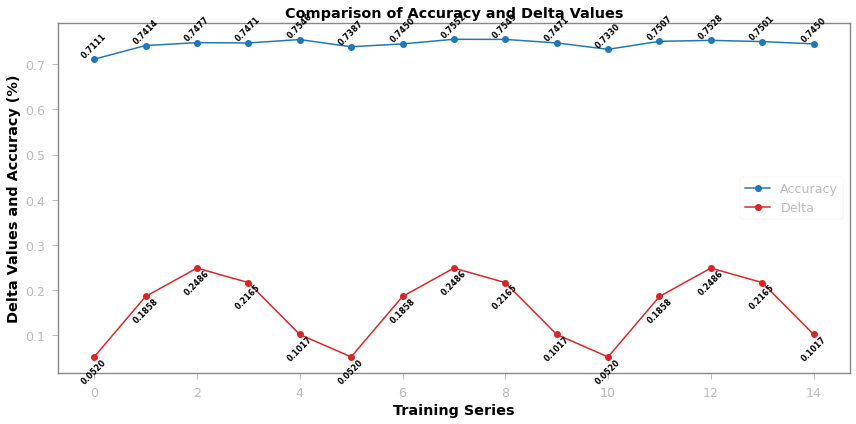

In [29]:

plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 87 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6580


epoch,train_loss,valid_loss,accuracy,time
0,0.158547,0.079436,0.721125,01:48


Better model found at epoch 0 with accuracy value: 0.7211246490478516.


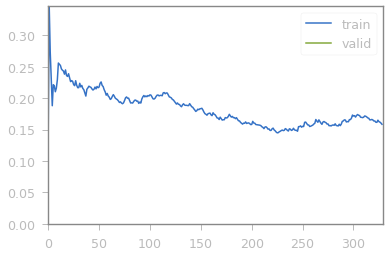

************Round:  0
TTA Accuracy:0.7305730581283569
cycle 0 Error Rate is [{0: (1.3049347532623323, 26.942694187164307)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 88 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6492


epoch,train_loss,valid_loss,accuracy,time
0,0.097394,0.036901,0.728043,01:47


Better model found at epoch 0 with accuracy value: 0.7280431389808655.


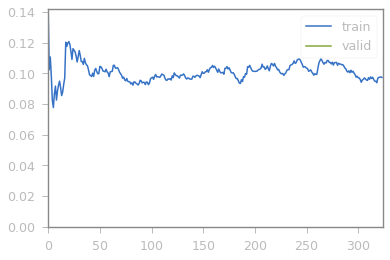

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 80 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6412


epoch,train_loss,valid_loss,accuracy,time
0,0.074632,0.023699,0.747270,01:45


Better model found at epoch 0 with accuracy value: 0.747269868850708.


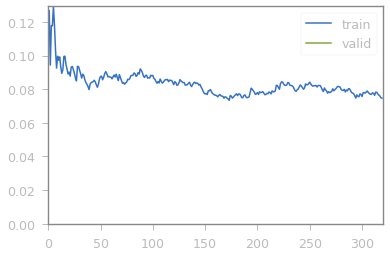

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 82 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6330


epoch,train_loss,valid_loss,accuracy,time
0,0.072004,0.021752,0.731438,01:43


Better model found at epoch 0 with accuracy value: 0.731437623500824.


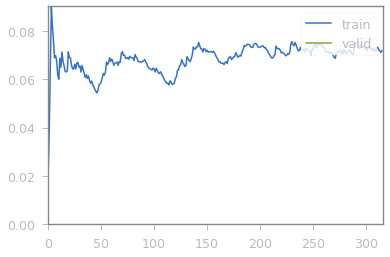

************Round:  3
TTA Accuracy:0.7461746335029602
cycle 0 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 73 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6257


epoch,train_loss,valid_loss,accuracy,time
0,0.064008,0.014901,0.719424,01:43


Better model found at epoch 0 with accuracy value: 0.7194244861602783.


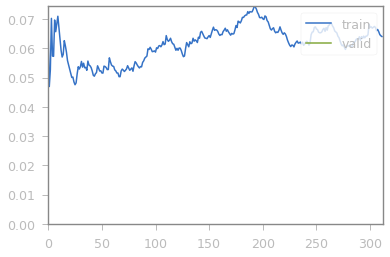

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 58
Min probability = 0.7909090909090909
Dropped 82 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6175


epoch,train_loss,valid_loss,accuracy,time
0,0.059069,0.014889,0.720648,01:41


Better model found at epoch 0 with accuracy value: 0.7206477522850037.


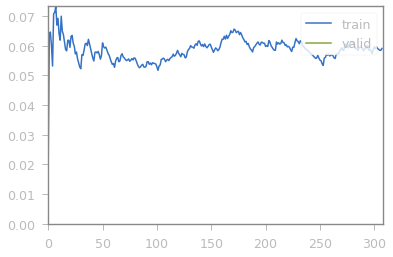

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 57
Min probability = 0.7772727272727273
Dropped 78 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6097


epoch,train_loss,valid_loss,accuracy,time
0,0.060727,0.015527,0.725185,01:40


Better model found at epoch 0 with accuracy value: 0.7251845598220825.


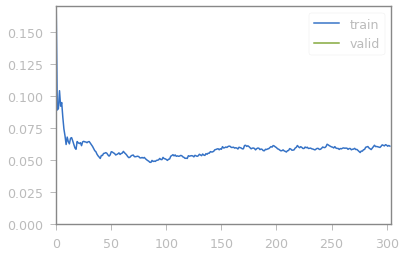

************Round:  6
TTA Accuracy:0.739874005317688
cycle 0 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 83 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6014


epoch,train_loss,valid_loss,accuracy,time
0,0.059047,0.012299,0.730449,01:40


Better model found at epoch 0 with accuracy value: 0.7304492592811584.


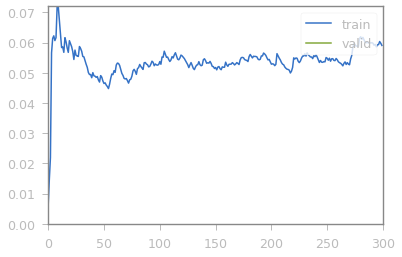

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 65
Min frequency is 54
Min probability = 0.7476923076923078
Dropped 72 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5942


epoch,train_loss,valid_loss,accuracy,time
0,0.049178,0.012158,0.728956,01:38


Better model found at epoch 0 with accuracy value: 0.7289562225341797.


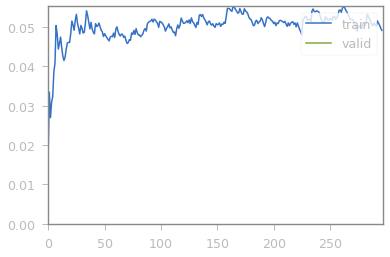

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 54
Min probability = 0.7476923076923078
Dropped 80 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5862


epoch,train_loss,valid_loss,accuracy,time
0,0.058145,0.012308,0.729522,01:37


Better model found at epoch 0 with accuracy value: 0.729522168636322.


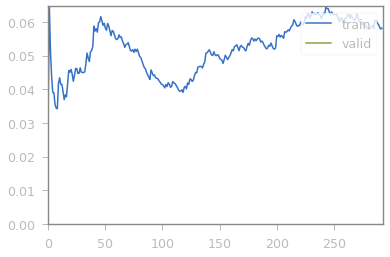

************Round:  9
TTA Accuracy:0.7431743144989014
cycle 0 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 52
Min probability = 0.7200000000000001
Dropped 76 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5786


epoch,train_loss,valid_loss,accuracy,time
0,0.053559,0.012193,0.752809,01:36


Better model found at epoch 0 with accuracy value: 0.7528089880943298.


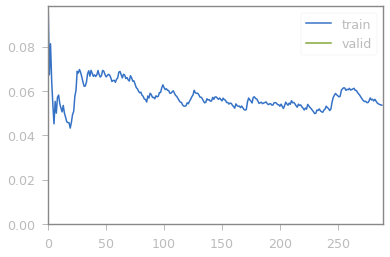

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 65
Min frequency is 52
Min probability = 0.7200000000000001
Dropped 68 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5718


epoch,train_loss,valid_loss,accuracy,time
0,0.062743,0.016049,0.720035,01:35


Better model found at epoch 0 with accuracy value: 0.7200350165367126.


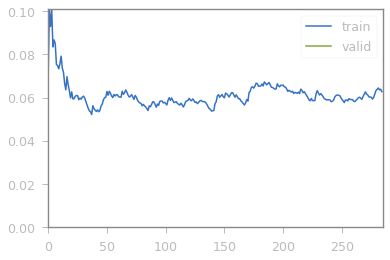

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 70 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5648


epoch,train_loss,valid_loss,accuracy,time
0,0.066109,0.015456,0.734278,01:34


Better model found at epoch 0 with accuracy value: 0.73427814245224.


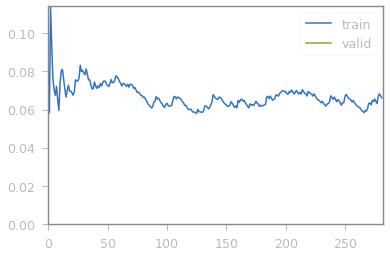

************Round:  12
TTA Accuracy:0.7458745837211609
cycle 0 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 63
Min frequency is 49
Min probability = 0.7000000000000001
Dropped 63 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5585


epoch,train_loss,valid_loss,accuracy,time
0,0.082421,0.016711,0.738585,01:33


Better model found at epoch 0 with accuracy value: 0.7385854721069336.


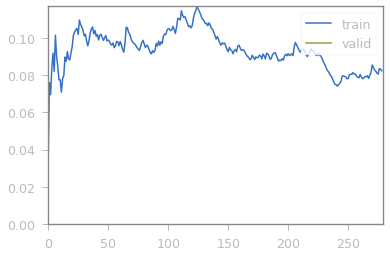

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 48
Min probability = 0.6857142857142857
Dropped 69 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5516


epoch,train_loss,valid_loss,accuracy,time
0,1.670471,1.831698,0.728921,01:34


Better model found at epoch 0 with accuracy value: 0.728921115398407.


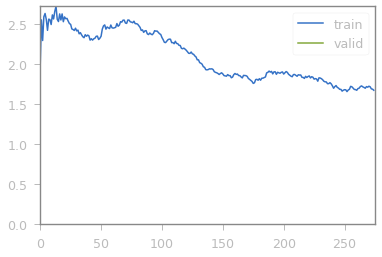

delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 95 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6572


epoch,train_loss,valid_loss,accuracy,time
0,0.124083,0.062580,0.728311,01:49


Better model found at epoch 0 with accuracy value: 0.7283105254173279.


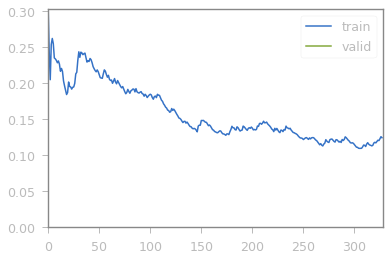

************Round:  0
TTA Accuracy:0.7305730581283569
cycle 1 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 89 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6483


epoch,train_loss,valid_loss,accuracy,time
0,0.077250,0.036894,0.732253,01:47


Better model found at epoch 0 with accuracy value: 0.7322530746459961.


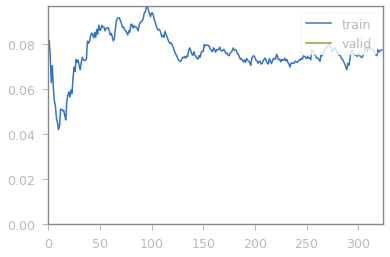

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 86 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6397


epoch,train_loss,valid_loss,accuracy,time
0,0.051751,0.016977,0.727912,01:44


Better model found at epoch 0 with accuracy value: 0.727912425994873.


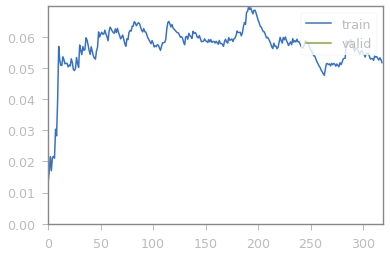

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 82 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6315


epoch,train_loss,valid_loss,accuracy,time
0,0.048734,0.016099,0.735550,01:44


Better model found at epoch 0 with accuracy value: 0.7355502843856812.


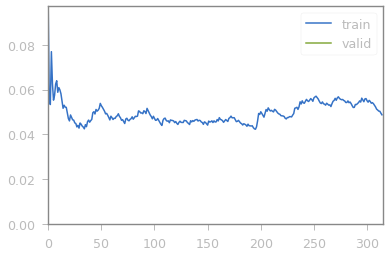

************Round:  3
TTA Accuracy:0.7497749924659729
cycle 1 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 80 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6235


epoch,train_loss,valid_loss,accuracy,time
0,0.038658,0.010880,0.732157,01:42


Better model found at epoch 0 with accuracy value: 0.7321571707725525.


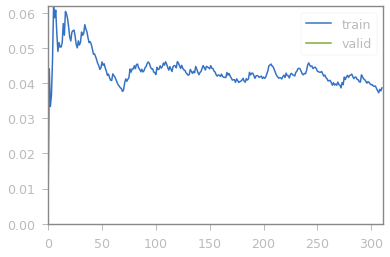

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 76 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6159


epoch,train_loss,valid_loss,accuracy,time
0,0.037708,0.010024,0.722989,01:41


Better model found at epoch 0 with accuracy value: 0.7229894399642944.


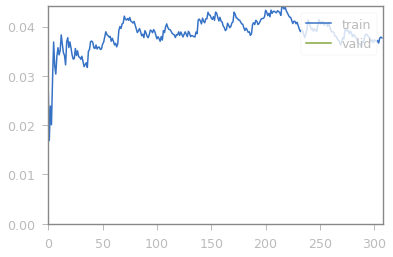

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 77 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6082


epoch,train_loss,valid_loss,accuracy,time
0,0.039162,0.007316,0.716283,01:40


Better model found at epoch 0 with accuracy value: 0.7162829041481018.


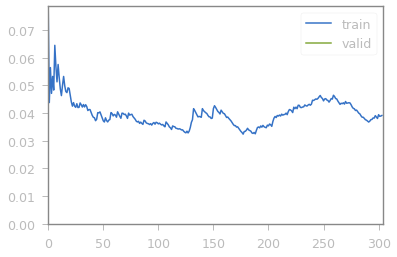

************Round:  6
TTA Accuracy:0.7524752616882324
cycle 1 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 66 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6016


epoch,train_loss,valid_loss,accuracy,time
0,0.039231,0.008952,0.727348,01:39


Better model found at epoch 0 with accuracy value: 0.727348268032074.


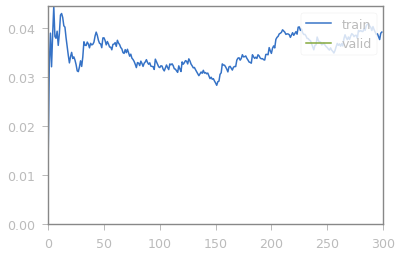

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 52
Min probability = 0.7090909090909091
Dropped 67 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5949


epoch,train_loss,valid_loss,accuracy,time
0,0.043291,0.007376,0.719092,01:38


Better model found at epoch 0 with accuracy value: 0.7190916538238525.


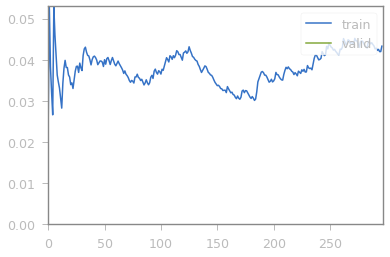

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 51
Min probability = 0.7061538461538461
Dropped 73 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5876


epoch,train_loss,valid_loss,accuracy,time
0,0.044070,0.006100,0.755745,01:37


Better model found at epoch 0 with accuracy value: 0.7557446956634521.


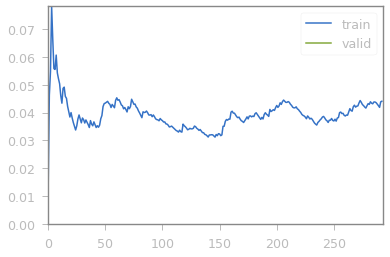

************Round:  9
TTA Accuracy:0.7467746734619141
cycle 1 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758), 24: (11.864406779661019, 25.322532653808594)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 63 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5813


epoch,train_loss,valid_loss,accuracy,time
0,0.035289,0.007365,0.728055,01:36


Better model found at epoch 0 with accuracy value: 0.7280550599098206.


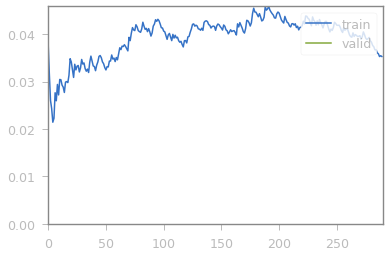

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 65
Min frequency is 48
Min probability = 0.6646153846153847
Dropped 65 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5748


epoch,train_loss,valid_loss,accuracy,time
0,0.044853,0.011457,0.732811,01:34


Better model found at epoch 0 with accuracy value: 0.7328111529350281.


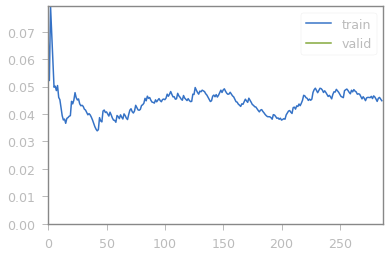

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 65
Min frequency is 47
Min probability = 0.6507692307692308
Dropped 61 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5687


epoch,train_loss,valid_loss,accuracy,time
0,0.049392,0.006183,0.724714,01:34


Better model found at epoch 0 with accuracy value: 0.7247141599655151.


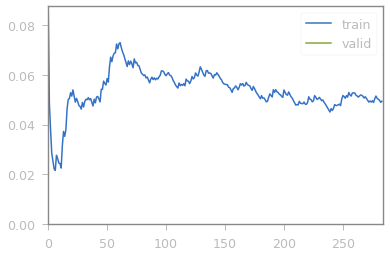

************Round:  12
TTA Accuracy:0.7479748129844666
cycle 1 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758), 24: (11.864406779661019, 25.322532653808594), 27: (14.699265036748166, 25.202518701553345)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 64
Min frequency is 47
Min probability = 0.6609375000000001
Dropped 65 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5622


epoch,train_loss,valid_loss,accuracy,time
0,0.052000,0.023635,0.737544,01:33


Better model found at epoch 0 with accuracy value: 0.7375444769859314.


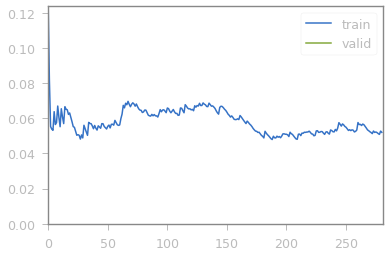

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 47
Min probability = 0.6714285714285715
Dropped 65 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5557


epoch,train_loss,valid_loss,accuracy,time
0,1.760347,1.700566,0.735374,01:32


Better model found at epoch 0 with accuracy value: 0.7353735566139221.


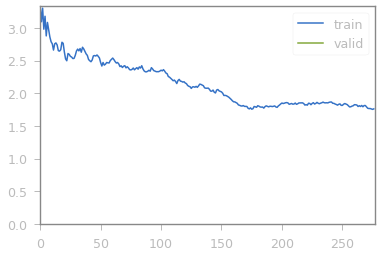

delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 92 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6575


epoch,train_loss,valid_loss,accuracy,time
0,0.095298,0.063937,0.711027,01:47


Better model found at epoch 0 with accuracy value: 0.7110266089439392.


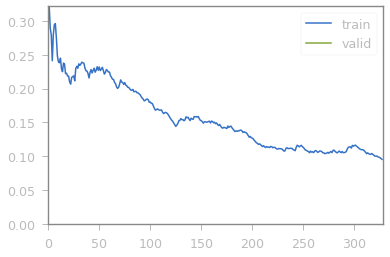

************Round:  0
TTA Accuracy:0.732073187828064
cycle 2 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758), 24: (11.864406779661019, 25.322532653808594), 27: (14.699265036748166, 25.202518701553345), 30: (1.3799310034498302, 26.792681217193604)}]
delta = 0.20336832153790008
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 84 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6491


epoch,train_loss,valid_loss,accuracy,time
0,0.050921,0.018602,0.747304,01:47


Better model found at epoch 0 with accuracy value: 0.7473035454750061.


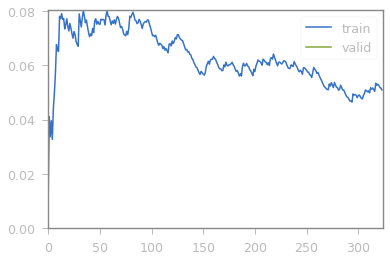

delta = 0.29389262614623657
+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 83 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6408


epoch,train_loss,valid_loss,accuracy,time
0,0.045249,0.009066,0.725995,01:45


Better model found at epoch 0 with accuracy value: 0.7259953022003174.


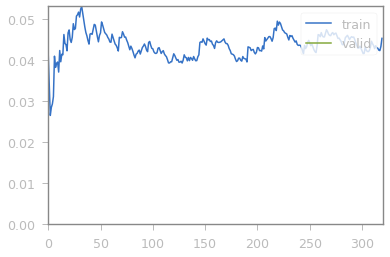

delta = 0.37157241273869707
+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 82 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6326


epoch,train_loss,valid_loss,accuracy,time
0,0.034362,0.006787,0.717787,01:44


Better model found at epoch 0 with accuracy value: 0.7177865505218506.


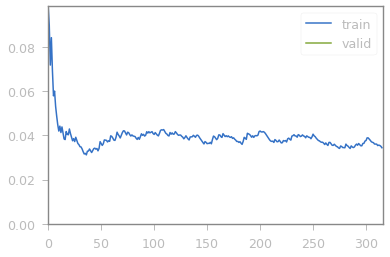

************Round:  3
TTA Accuracy:0.7419741749763489
cycle 2 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758), 24: (11.864406779661019, 25.322532653808594), 27: (14.699265036748166, 25.202518701553345), 30: (1.3799310034498302, 26.792681217193604), 33: (5.114744262786863, 25.802582502365112)}]
delta = 0.4330127018922193
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 79 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6247


epoch,train_loss,valid_loss,accuracy,time
0,0.040716,0.005522,0.730985,01:43


Better model found at epoch 0 with accuracy value: 0.7309848070144653.


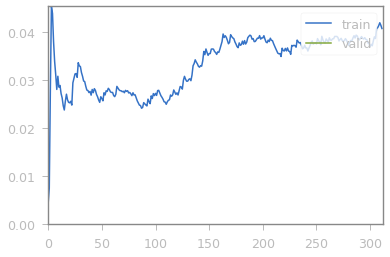

delta = 0.47552825814757677
+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 82 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6165


epoch,train_loss,valid_loss,accuracy,time
0,0.035349,0.005074,0.734793,01:41


Better model found at epoch 0 with accuracy value: 0.7347931861877441.


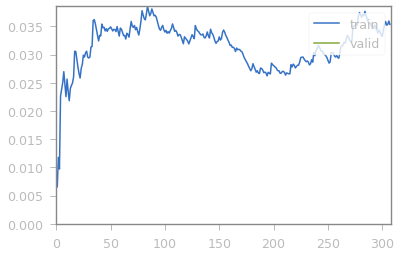

delta = 0.49726094768413664
+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 83 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6082


epoch,train_loss,valid_loss,accuracy,time
0,0.029781,0.007935,0.717105,01:40


Better model found at epoch 0 with accuracy value: 0.7171052694320679.


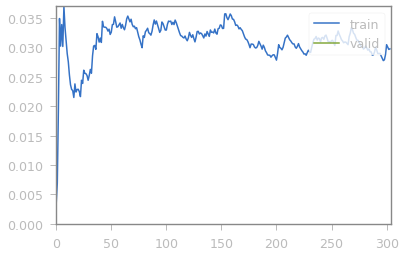

************Round:  6
TTA Accuracy:0.7308731079101562
cycle 2 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758), 24: (11.864406779661019, 25.322532653808594), 27: (14.699265036748166, 25.202518701553345), 30: (1.3799310034498302, 26.792681217193604), 33: (5.114744262786863, 25.802582502365112), 36: (8.774561271936399, 26.912689208984375)}]
delta = 0.4972609476841367
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 71 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6011


epoch,train_loss,valid_loss,accuracy,time
0,0.033646,0.005637,0.739601,01:39


Better model found at epoch 0 with accuracy value: 0.739600658416748.


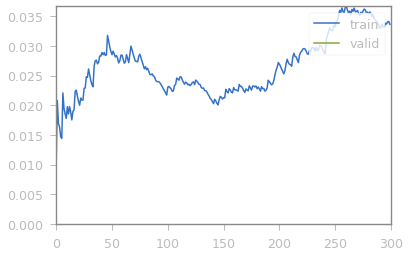

delta = 0.4755282581475768
+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 74 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5937


epoch,train_loss,valid_loss,accuracy,time
0,0.024911,0.006916,0.716933,01:38


Better model found at epoch 0 with accuracy value: 0.7169334292411804.


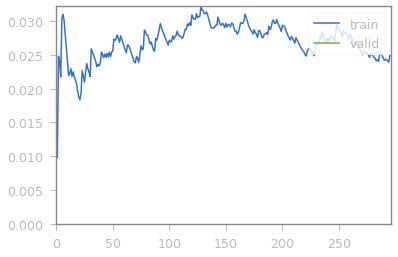

delta = 0.43301270189221935
+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 66
Min frequency is 54
Min probability = 0.7363636363636364
Dropped 73 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5864


epoch,train_loss,valid_loss,accuracy,time
0,0.030207,0.005166,0.708191,01:37


Better model found at epoch 0 with accuracy value: 0.7081910967826843.


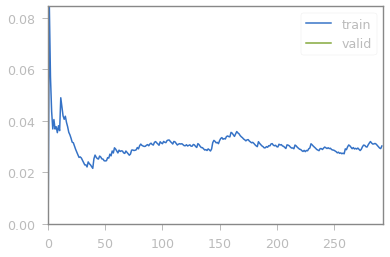

************Round:  9
TTA Accuracy:0.7386738657951355
cycle 2 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758), 24: (11.864406779661019, 25.322532653808594), 27: (14.699265036748166, 25.202518701553345), 30: (1.3799310034498302, 26.792681217193604), 33: (5.114744262786863, 25.802582502365112), 36: (8.774561271936399, 26.912689208984375), 39: (12.044397780110994, 26.13261342048645)}]
delta = 0.37157241273869723
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 71 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5793


epoch,train_loss,valid_loss,accuracy,time
0,0.032863,0.006819,0.720207,01:35


Better model found at epoch 0 with accuracy value: 0.7202072739601135.


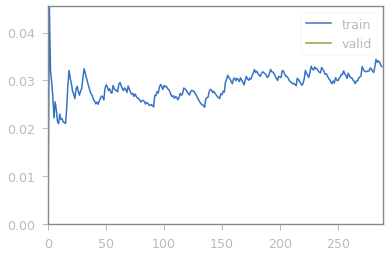

delta = 0.2938926261462366
+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 64
Min frequency is 52
Min probability = 0.7312500000000001
Dropped 74 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5719


epoch,train_loss,valid_loss,accuracy,time
0,0.033249,0.005426,0.719160,01:34


Better model found at epoch 0 with accuracy value: 0.7191600799560547.


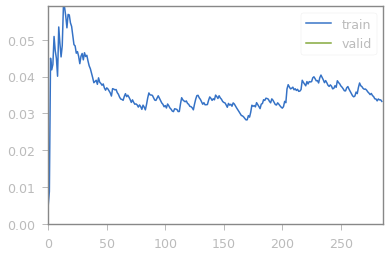

delta = 0.20336832153790002
+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 63
Min frequency is 51
Min probability = 0.7285714285714286
Dropped 67 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5652


epoch,train_loss,valid_loss,accuracy,time
0,0.049199,0.009587,0.730088,01:33


Better model found at epoch 0 with accuracy value: 0.730088472366333.


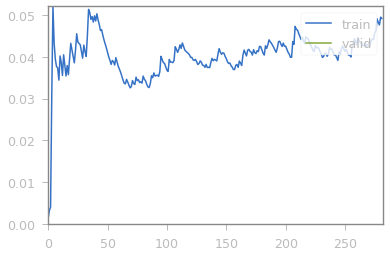

************Round:  12
TTA Accuracy:0.7380738258361816
cycle 2 Error Rate is [{0: (1.3049347532623323, 26.942694187164307), 3: (5.054747262636871, 25.38253664970398), 6: (8.549572521373927, 26.0125994682312), 9: (12.074396280185995, 25.682568550109863), 12: (15.284235788210587, 25.41254162788391), 15: (1.4249287535623267, 26.942694187164307), 18: (5.279736013199344, 25.02250075340271), 21: (8.774561271936399, 24.752473831176758), 24: (11.864406779661019, 25.322532653808594), 27: (14.699265036748166, 25.202518701553345), 30: (1.3799310034498302, 26.792681217193604), 33: (5.114744262786863, 25.802582502365112), 36: (8.774561271936399, 26.912689208984375), 39: (12.044397780110994, 26.13261342048645), 42: (15.224238788060596, 26.192617416381836)}]
delta = 0.10395584540887966
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 62
Min frequency is 49
Min probability = 0.7112903225806452
Dropped 70 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5582


epoch,train_loss,valid_loss,accuracy,time
0,0.052097,0.015314,0.723118,01:32


Better model found at epoch 0 with accuracy value: 0.7231183052062988.


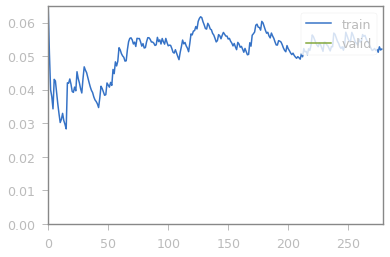

delta = 2.83276944882399e-16
+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 62
Min frequency is 47
Min probability = 0.682258064516129
Dropped 64 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5518


epoch,train_loss,valid_loss,accuracy,time
0,1.794298,1.695102,0.741614,01:31


Better model found at epoch 0 with accuracy value: 0.7416138052940369.


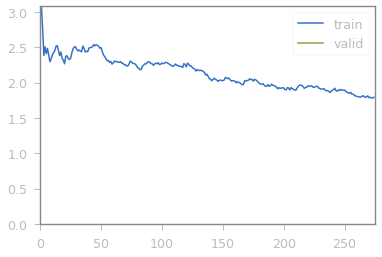

In [32]:
delta_max = 0.50
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        print(f'delta = {delta}')
        loss_func = losses.DampedCELossFlat(num_classes=196,delta=delta,reduction ='mean')        
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH="models/ce_aircrafts_damps25_Cls_sym40_b4_"+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv("CSVz/ce_aircrafts_damps25_Cls_sym40_b4_"+str(c)+"_"+str(n)+".csv", index = False)     
    

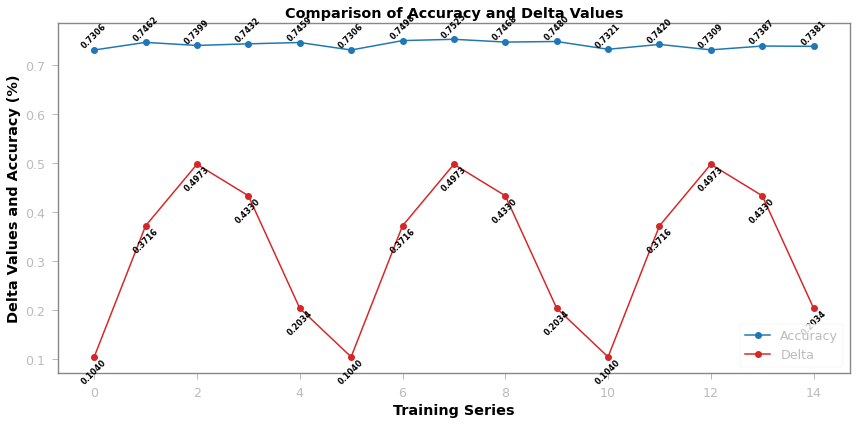

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
